In [1]:
import sys
import os

# This adds the parent directory (root) to the python path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# load data
import pandas as pd

df = pd.read_csv("../data/data.csv")
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,word_share,freq_sum,freq_diff,first_word,last_word,len_diff
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,91.67,1.386294,0.000000,1,0,2
1,1,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,0,41.18,2.708050,0.510826,1,0,5
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,20.00,1.386294,0.000000,1,0,4
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math twenty three twen...,0,0.00,1.386294,0.000000,0,0,6
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0,25.00,2.079442,0.693147,1,0,6


In [3]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-miniLM-L6-v2")
print(model)

c:\Users\Rahul\Documents\Personal Projects\.py\question-similarity\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False, 'architecture': 'BertModel'})
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)


In [ ]:
from sentence_transformers import SimilarityFunction

# using dot product since already normalized
model.similarity_fn_name = SimilarityFunction.DOT_PRODUCT

# getting all the unique questions only
questions = pd.concat([df["question1"], df["question2"]]).unique().tolist()

# creating multi process pool for parallel
embeddings = model.encode(questions, device="cuda", show_progress_bar=True)

# generating a dictionary of questions and their embeddings
cache = dict(zip(questions, embeddings))

Batches: 100%|██████████| 16734/16734 [04:34<00:00, 60.93it/s]


In [ ]:
import numpy as np
import torch

q1_embeddings = torch.tensor(np.stack(df["question1"].map(cache).values))
q2_embeddings = torch.tensor(np.stack(df["question2"].map(cache).values))

similarity_scores = model.similarity_pairwise(q1_embeddings, q2_embeddings)
df["sim_score"] = similarity_scores

In [8]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,word_share,freq_sum,freq_diff,first_word,last_word,len_diff,sim_score
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,91.67,1.386294,0.000000,1,0,2,0.891514
1,1,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,0,41.18,2.708050,0.510826,1,0,5,0.667445
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,20.00,1.386294,0.000000,1,0,4,0.499448
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math twenty three twen...,0,0.00,1.386294,0.000000,0,0,6,0.172758
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0,25.00,2.079442,0.693147,1,0,6,0.212026


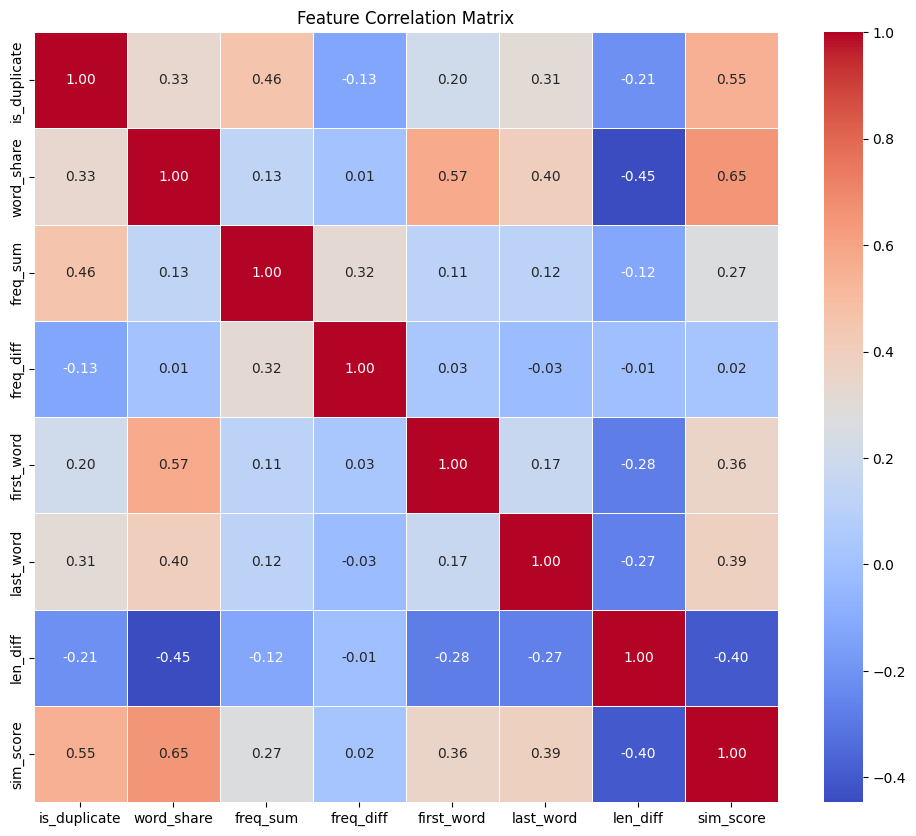

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

features = df.drop(columns=["id", "qid1", "qid2", "question1", "question2"]).columns
corr_matrix = df[features].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidth=0.5)
plt.title("Feature Correlation Matrix")
plt.show()